In [106]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [107]:
dataset = CIFAR10(root='C:/Users/prave/Desktop/Projects/Data', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='C:/Users/prave/Desktop/Projects/Data', train=False, transform=ToTensor())

Files already downloaded and verified


In [108]:
val_size = 10000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(40000, 10000)

In [109]:
batch_size=128

In [110]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([128, 3, 32, 32])


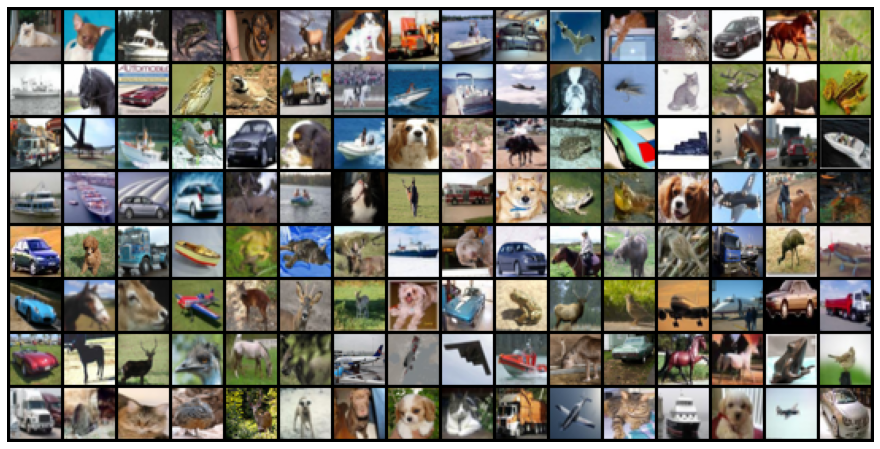

In [111]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [112]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [113]:
class CIFAR10(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, out_size):
        super().__init__()
        # Input Layer
        self.linear1 = nn.Linear(in_size, 1024)
        # hidden layer 1
        self.linear2 = nn.Linear(1024, 512)
        # hidden layer 2
        self.linear3 = nn.Linear(512, 128)
        # hidden layer 3
        self.linear4 = nn.Linear(128, 32)
        # Output Layer
        self.linear5 = nn.Linear(32, out_size) 
        
    def forward(self, xb):
        # Flatten the image tensors
        out = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer 1
        out = self.linear1(out)
        # Apply activation function
        out = F.relu(out)
        # Get intermediate outputs using hidden layer 2
        out = self.linear2(out)
        # Apply activation function
        out = F.relu(out)
        # Get intermediate outputs using hidden layer 3
        out = self.linear3(out)
        # Apply activation function
        out = F.relu(out)
        # Get intermediate outputs using hidden layer 4
        out = self.linear4(out)
        # Apply activation function
        out = F.relu(out)
        # Final Predictions
        out = self.linear5(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [114]:
torch.cuda.is_available()

True

In [115]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [116]:
device = get_default_device()
device

device(type='cuda')

In [117]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [118]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [119]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [120]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [121]:
input_size = 3*32*32
num_classes = 10

In [122]:
model = CIFAR10(input_size, out_size=num_classes)
to_device(model, device)


CIFAR10(
  (linear1): Linear(in_features=3072, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=128, bias=True)
  (linear4): Linear(in_features=128, out_features=32, bias=True)
  (linear5): Linear(in_features=32, out_features=10, bias=True)
)

In [123]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.30627703666687, 'val_acc': 0.09804687649011612}]

In [124]:
history += fit(20, 0.1, model, train_loader, val_loader)
history += fit(20, 0.01, model, train_loader, val_loader)
history += fit(30, 0.001, model, train_loader, val_loader)
history += fit(30, 0.0001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9813, val_acc: 0.2635
Epoch [1], val_loss: 1.9061, val_acc: 0.2957
Epoch [2], val_loss: 1.8766, val_acc: 0.3275
Epoch [3], val_loss: 1.7781, val_acc: 0.3539
Epoch [4], val_loss: 1.7317, val_acc: 0.3721
Epoch [5], val_loss: 1.6886, val_acc: 0.3759
Epoch [6], val_loss: 1.6622, val_acc: 0.3987
Epoch [7], val_loss: 1.5689, val_acc: 0.4415
Epoch [8], val_loss: 1.5568, val_acc: 0.4391
Epoch [9], val_loss: 1.6157, val_acc: 0.4343
Epoch [10], val_loss: 1.5793, val_acc: 0.4405
Epoch [11], val_loss: 1.5442, val_acc: 0.4427
Epoch [12], val_loss: 1.5695, val_acc: 0.4365
Epoch [13], val_loss: 1.5260, val_acc: 0.4594
Epoch [14], val_loss: 1.5481, val_acc: 0.4446
Epoch [15], val_loss: 1.5095, val_acc: 0.4638
Epoch [16], val_loss: 1.5098, val_acc: 0.4656
Epoch [17], val_loss: 1.4386, val_acc: 0.4869
Epoch [18], val_loss: 1.4713, val_acc: 0.4799
Epoch [19], val_loss: 1.4657, val_acc: 0.4846
Epoch [0], val_loss: 1.3222, val_acc: 0.5428
Epoch [1], val_loss: 1.3189, val_acc: 0.5419


In [125]:
import matplotlib.pyplot as plt
%matplotlib inline

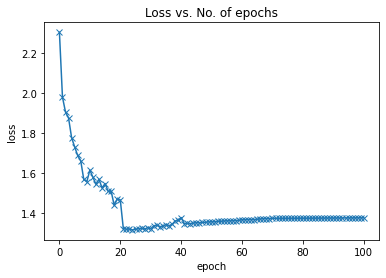

In [126]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

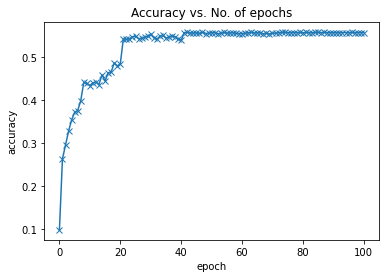

In [127]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [128]:
!pip install jovian --upgrade -q

In [129]:
import jovian

<IPython.core.display.Javascript object>

In [131]:
jovian.commit(project='cifar10-feed-forward-pytorch', environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/praveenr2998/cifar10-feed-forward-pytorch


<IPython.core.display.Javascript object>